In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from NMT_preprocessing import prepare_data
from NMT_preprocessing import construct_vectors
from NMT_preprocessing import random_batch
from NMT_model import EncoderRNN
from NMT_model import AttnDecoderRNN
from NMT_model import train
from NMT_utils import as_minutes
from NMT_utils import time_since

import time
import random
import torch.nn as nn
from torch import optim

import torchtext 
from torchtext import data
from torchtext import datasets

## Loading data

In [12]:
USE_CUDA = True
MAX_LENGTH = 15

In [13]:
input_lang, output_lang, pairs = prepare_data('parallel-corpora/eng-es/eng-spa.txt',
                                    'eng', 'spa', MAX_LENGTH)

Reading lines...
Read 114282 sentence pairs
Trimmed to 111263 sentence pairs
Indexing words...


In [14]:
eng, spa = construct_vectors(pairs)

Loading vectors from .vector_cache/wiki.en.vec.pt
Loading vectors from .vector_cache/wiki.es.vec.pt


In [15]:
random.seed(42)
random.shuffle(pairs, random.random)

train_data = pairs[:-1000]
val_data = pairs[-1000:]

In [16]:
input_lang.n_words, eng.vocab.vectors.shape, output_lang.n_words, spa.vocab.vectors.shape

(12375, torch.Size([12375, 300]), 23553, torch.Size([23553, 300]))

## Training model

In [7]:
attn_model = 'general'
embedding_size = 300
hidden_size = 512
n_layers = 2
encoder_dropout_p = 0.0
decoder_dropout_p = 0.5

n_epochs = 5000
plot_every = 10
print_every = 10
validate_every = 50
train_losses = []
validation_losses = []
print_loss_total = 0
plot_loss_total = 0

batch_size = 128

In [8]:
encoder = EncoderRNN(input_lang.n_words, embedding_size, hidden_size, batch_size, 
                     n_layers, encoder_dropout_p, eng, USE_CUDA)
decoder = AttnDecoderRNN(output_lang.n_words, embedding_size, hidden_size, 
                         attn_model, n_layers * 2, decoder_dropout_p, spa, USE_CUDA)
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()
    
learning_rate = 0.001
encoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad, encoder.parameters()), lr=learning_rate)
decoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad, decoder.parameters()), lr=learning_rate)
criterion = nn.NLLLoss()

In [10]:
input_lang.n_words, eng.vocab.vectors.shape, output_lang.n_words, spa.vocab.vectors.shape

(12375, torch.Size([12375, 300]), 23553, torch.Size([23553, 300]))

In [31]:
encoder = EncoderRNN(input_lang.n_words, embedding_size, hidden_size, batch_size, 
                     n_layers, encoder_dropout_p, eng, USE_CUDA)
decoder = AttnDecoderRNN(output_lang.n_words, embedding_size, hidden_size, 
                         attn_model, n_layers * 2, decoder_dropout_p, spa, USE_CUDA)
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()
    
learning_rate = 0.001
encoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad, encoder.parameters()), lr=learning_rate)
decoder_optimizer = optim.Adam(filter(lambda p: p.requires_grad, decoder.parameters()), lr=learning_rate)
criterion = nn.NLLLoss()

In [32]:
from NMT_model import train

start = time.time()
for epoch in range(1, n_epochs + 1):  
    input_batches, input_lengths, target_batches, target_lengths = random_batch(
                batch_size, input_lang, output_lang, train_data, USE_CUDA)
    
    loss = train(input_batches, input_lengths, target_batches, target_lengths,\
                 encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, 
                 USE_CUDA, train=True)
    
    print_loss_total += loss
    plot_loss_total += loss
    
    if epoch == 0: continue
        
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print(f'{time_since(start, epoch / n_epochs)} ({epoch} {epoch / n_epochs * 100:.2f}%) train_loss: {print_loss_avg:.4f}', end=' ')
    
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        train_losses.append(plot_loss_avg)
        plot_loss_total = 0
        
    if epoch % validate_every == 0:
        input_batches, input_lengths, target_batches, target_lengths = random_batch(
                batch_size, input_lang, output_lang, val_data)
    
        eval_loss = train(input_batches, input_lengths, target_batches, target_lengths,\
                     encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, 
                     USE_CUDA, train=False)
        
        validation_losses.append(eval_loss)
        print(f'- val_loss: {eval_loss:.4f}', end='')
    
    if epoch % print_every == 0:
        print()

0m 4s (- 39m 39s) (10 0.20%) train_loss: 6.3460 
0m 9s (- 38m 39s) (20 0.40%) train_loss: 3.2767 
0m 13s (- 37m 57s) (30 0.60%) train_loss: 3.1717 
0m 18s (- 38m 13s) (40 0.80%) train_loss: 2.8422 
0m 23s (- 38m 23s) (50 1.00%) train_loss: 2.7991 - val_loss: 3.2673
0m 28s (- 38m 26s) (60 1.20%) train_loss: 2.8490 
0m 32s (- 38m 18s) (70 1.40%) train_loss: 2.9147 
0m 37s (- 38m 9s) (80 1.60%) train_loss: 2.8253 
0m 41s (- 37m 59s) (90 1.80%) train_loss: 2.8144 
0m 46s (- 37m 51s) (100 2.00%) train_loss: 2.8469 - val_loss: 3.2423
0m 51s (- 38m 2s) (110 2.20%) train_loss: 2.6776 
0m 56s (- 38m 0s) (120 2.40%) train_loss: 2.7310 
1m 0s (- 37m 56s) (130 2.60%) train_loss: 2.7418 
1m 5s (- 37m 52s) (140 2.80%) train_loss: 2.7330 
1m 10s (- 37m 52s) (150 3.00%) train_loss: 2.7361 - val_loss: 3.3382
1m 15s (- 37m 55s) (160 3.20%) train_loss: 2.7361 
1m 19s (- 37m 51s) (170 3.40%) train_loss: 2.6863 
1m 24s (- 37m 40s) (180 3.60%) train_loss: 2.7258 
1m 28s (- 37m 28s) (190 3.80%) train_loss: 2

## Evaluating model

In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from NMT_utils import show_plot
from NMT_utils import plot_losses

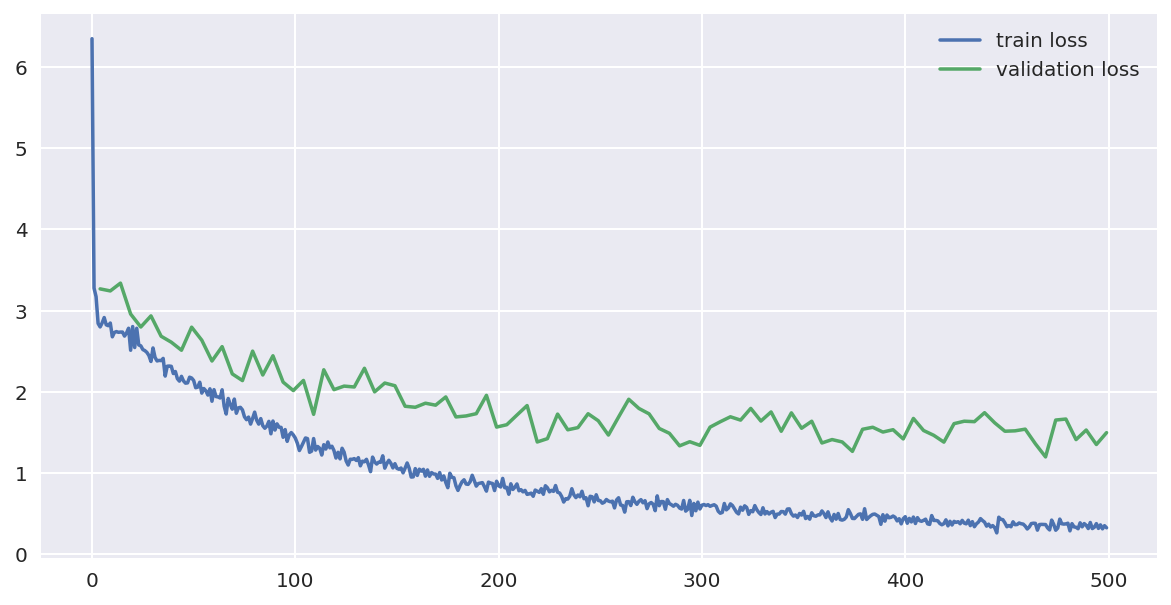

In [34]:
# With frozen pre trained embeddings and hidden size = 512, 8000 epochs, batch size 128
plot_losses(train_losses, validation_losses, validate_every // plot_every)

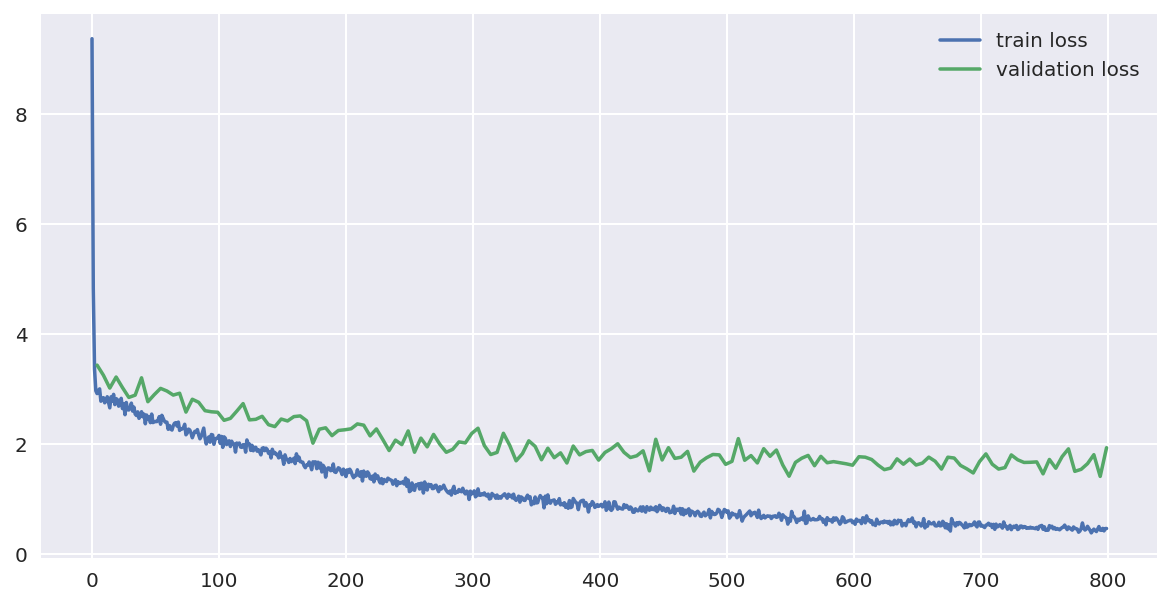

In [11]:
# With frozen pre trained embeddings and hidden size = 512, 8000 epochs, batch size 128
plot_losses(train_losses, validation_losses, validate_every // plot_every)

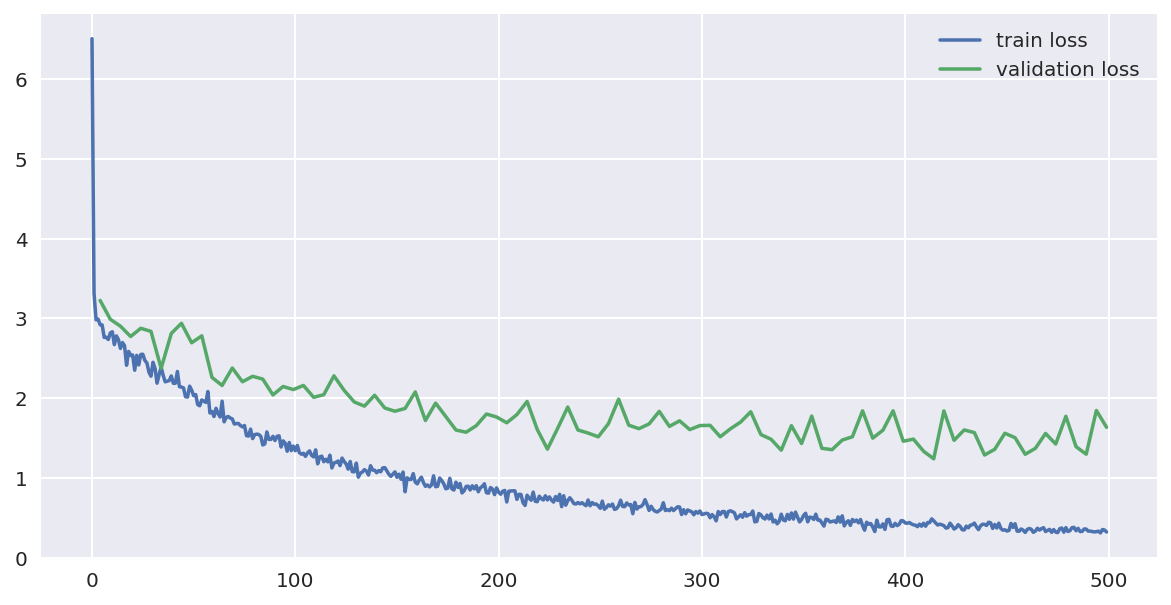

In [49]:
# With frozen pre trained embeddings and hidden size = 512
plot_losses(train_losses, validation_losses, validate_every // plot_every)

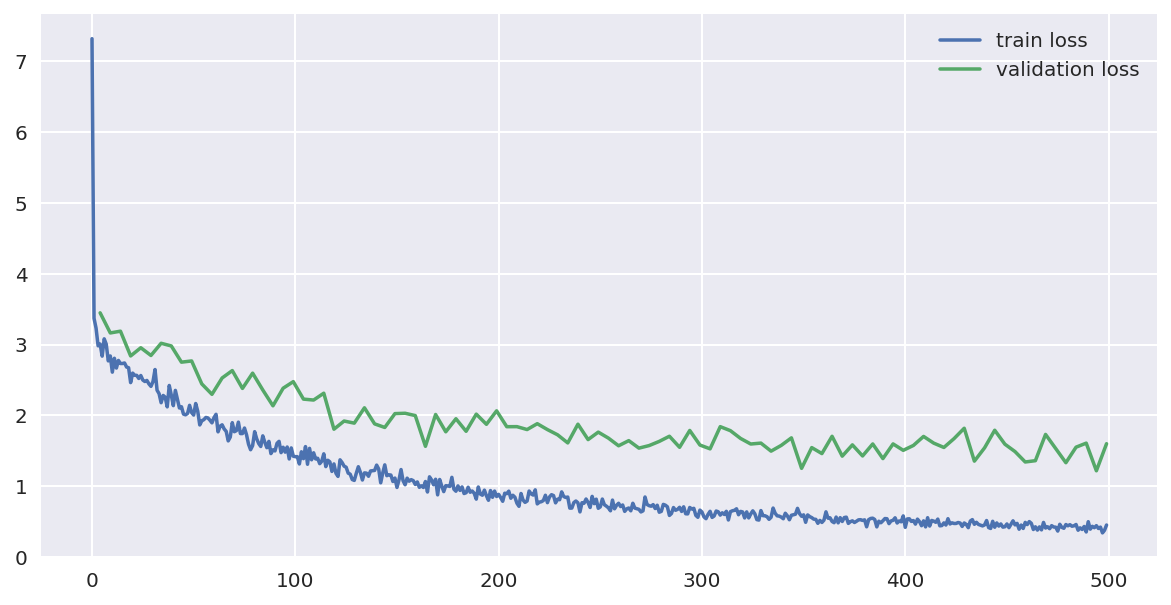

In [13]:
# With pre trained embeddings and hidden size = 300
plot_losses(train_losses, validation_losses, validate_every // plot_every)

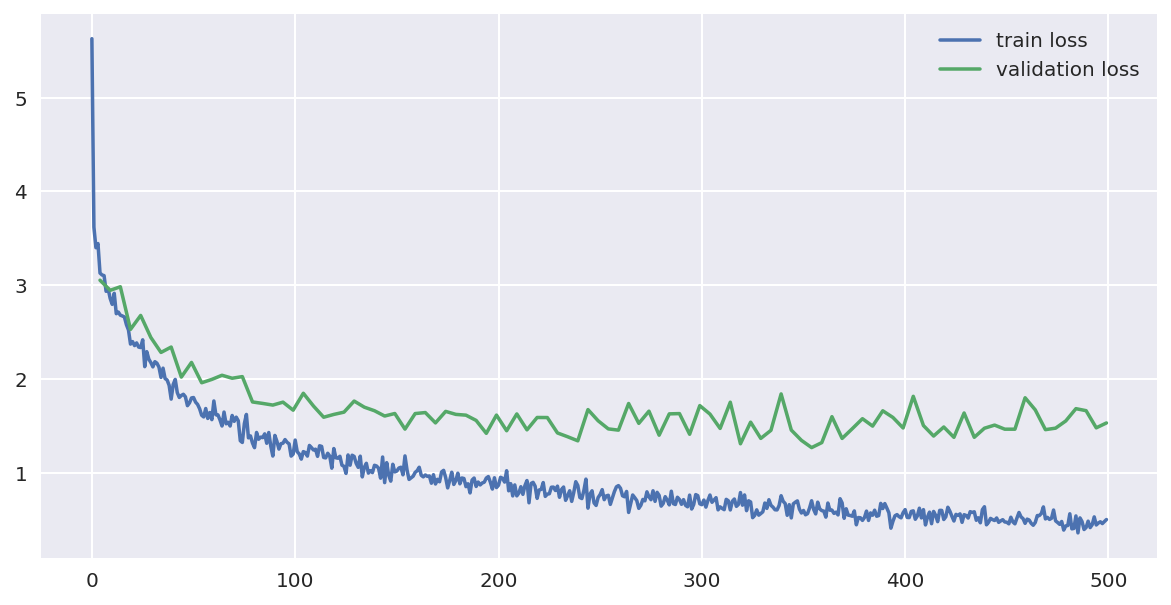

In [295]:
plot_losses(train_losses, validation_losses, validate_every // plot_every)

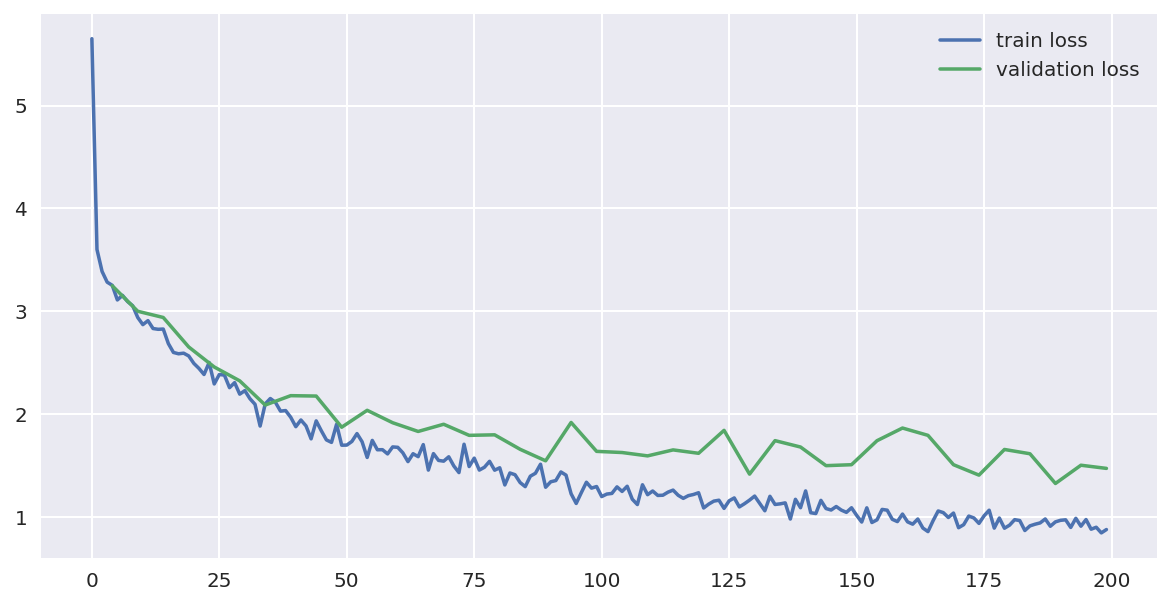

In [51]:
plot_losses(train_losses, validation_losses, validate_every // plot_every)

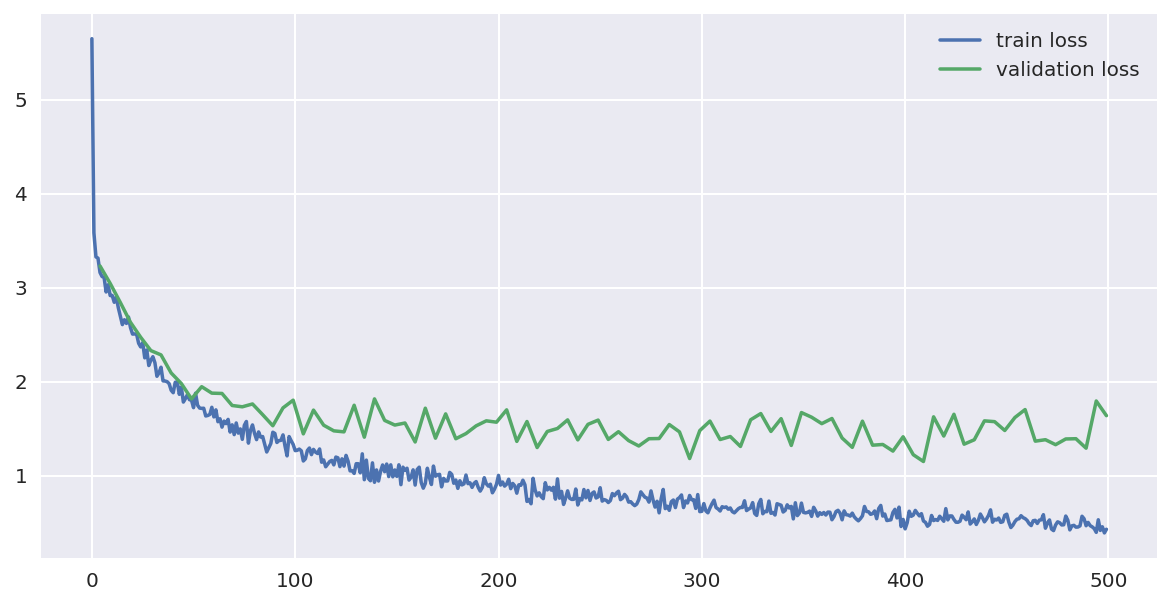

In [84]:
plot_losses(train_losses, validation_losses, validate_every // plot_every)

In [35]:
from NMT_evaluation import Evaluator

In [36]:
evaluator = Evaluator(encoder, decoder, input_lang, output_lang, 
                      MAX_LENGTH, USE_CUDA)

In [37]:
for k in [1, 3, 8, 15]:
    evaluator.evaluate_sentence('i d like to sit by the window .', k_beams=k)

> i d like to sit by the window .
< yo gustaria sentarme junto la ventana . <EOS>

> i d like to sit by the window .
< yo gustaria sentarme junto la la ventana . <EOS>

> i d like to sit by the window .
< yo gustaria sentarme junto la ventana . <EOS>

> i d like to sit by the window .
< me gustaria sentarme junto la ventana . <EOS>



In [18]:
for k in [1, 3, 8, 15]:
    evaluator.evaluate_sentence('i d like to sit by the window .', k_beams=k)

> i d like to sit by the window .
< me gustaria sentarme por la ventana . <EOS>

> i d like to sit by the window .
< me gustaria sentarme por la ventana . <EOS>

> i d like to sit by the window .
< me gustaria sentarme por la ventana . <EOS>

> i d like to sit by the window .
< me gustaria sentarme por la ventana . <EOS>



In [24]:
evaluator.evaluate_randomly(val_data, k_beams=10)

['i decided to study abroad .' 'decidi estudiar en el extranjero .']
> i decided to study abroad .
= decidi estudiar en el extranjero .
< me estudiar estudiar . <EOS>



In [23]:
evaluator.evaluate_sentence('there is a man at the door who wants to see you .', k_beams=1)

> there is a man at the door who wants to see you .
< hay un hombre a puerta a a verte verte . <EOS>



In [211]:
evaluator.evaluate_randomly(val_data, k_beams=15)

['i want you to watch this video .', 'quiero que veas este video .']
['quiero', 'que', 'veas', 'este', 'video', '<EOS>'] -1.0847047170003254
['quiero', 'que', 'conozcas', 'este', 'video', '<EOS>'] -1.248164176940918
['quiero', 'que', 'traduzcas', 'este', 'video', '<EOS>'] -1.30464768409729
['quiero', 'que', 'reloj', 'este', 'video', '<EOS>'] -1.289457639058431
['quiero', 'que', 'vean', 'este', 'video', '<EOS>'] -1.463553746541341
['quiero', 'que', 'conocieras', 'este', 'video', '<EOS>'] -1.4848483403523762
['quiero', 'que', 'tradujeras', 'este', 'video', '<EOS>'] -1.5372974872589111
['quiero', 'que', 'veas', 'esto', 'este', '<EOS>'] -1.570027192433675
['quiero', 'que', 'veas', 'este', 'este', '<EOS>'] -1.365821123123169
['quiero', 'que', 'arreglar', 'este', 'video', '<EOS>'] -1.5172014236450195
['quiero', 'que', 'veas', 'esta', 'video', '<EOS>'] -1.578251600265503
['quiero', 'que', 'seas', 'este', 'video', '<EOS>'] -1.532956838607788
['quiero', 'que', 'reloj', 'este', 'este', '<EOS>'] 

In [30]:
evaluator.evaluate_randomly(train_data)

['where are your parents ?' 'donde estan tus padres ?']
> where are your parents ?
= donde estan tus padres ?
< donde estan tus padres ? <EOS>



In [31]:
evaluator.evaluate_randomly(val_data)

['he came back from china .' 'el volvio de china .']
> he came back from china .
= el volvio de china .
< el volvio de china . <EOS>



In [32]:
evaluator.evaluate_randomly(train_data)

['you wait and see .' 'espera y veras .']
> you wait and see .
= espera y veras .
< espera y veamos . <EOS>



['who is in this room ?' 'quien esta en esta habitacion ?']
input = who is in this room ?
output = quien esta en este habitacion ? <EOS>


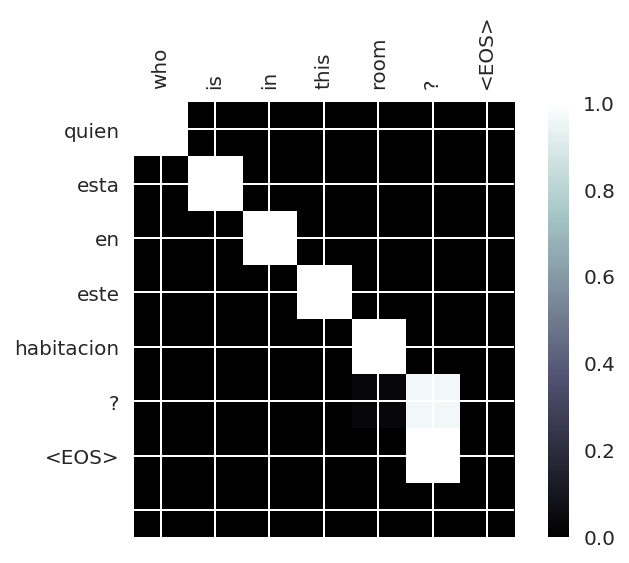

In [84]:
evaluator.evaluate_randomly_and_show_attention(val_data)

['could you tell me how to get to your office ?', 'podria usted decirme como llegar a su oficina ?']
input = could you tell me how to get to your office ?
output = podrias decirme como llegar a tu oficina ? <EOS>


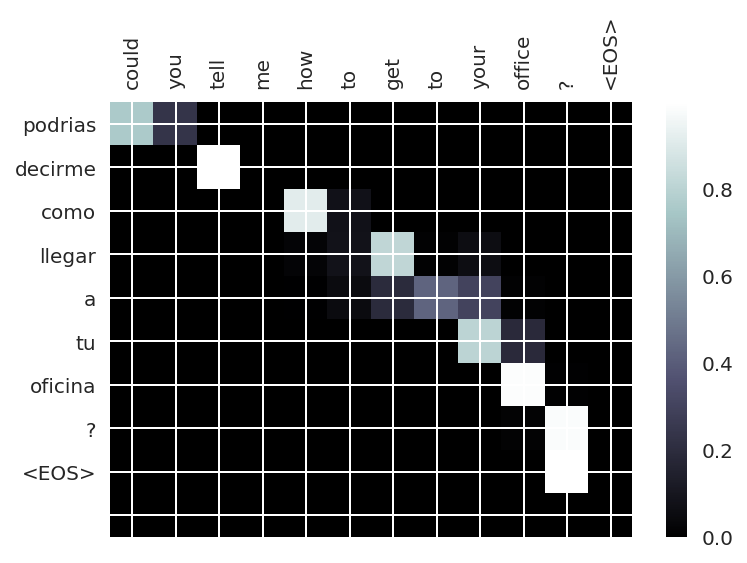

In [279]:
evaluator.evaluate_randomly_and_show_attention(val_data)

['there is a man at the door who wants to see you .', 'en la puerta hay un hombre que quiere verte .']
input = there is a man at the door who wants to see you .
output = hay un hombre junto a la puerta que quiere verte . <EOS>


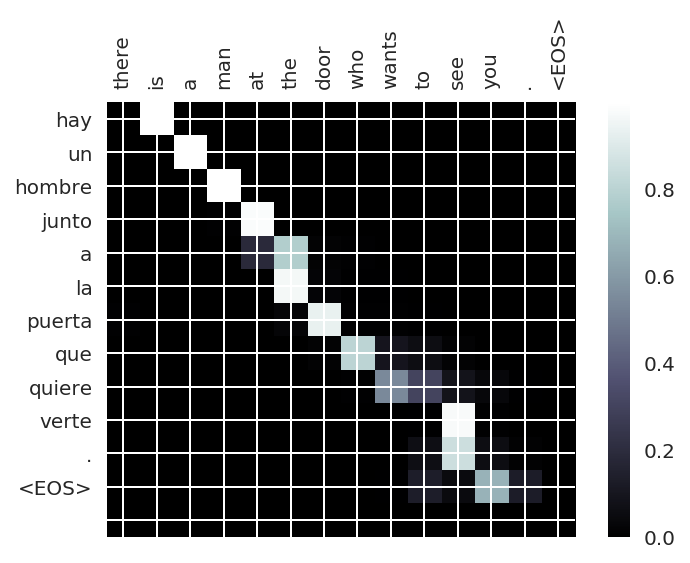

In [221]:
evaluator.evaluate_randomly_and_show_attention(val_data)

['oh ! that s too bad .', 'oh ! eso es terrible .']
input = oh ! that s too bad .
output = oh ! es demasiado malo . <EOS>


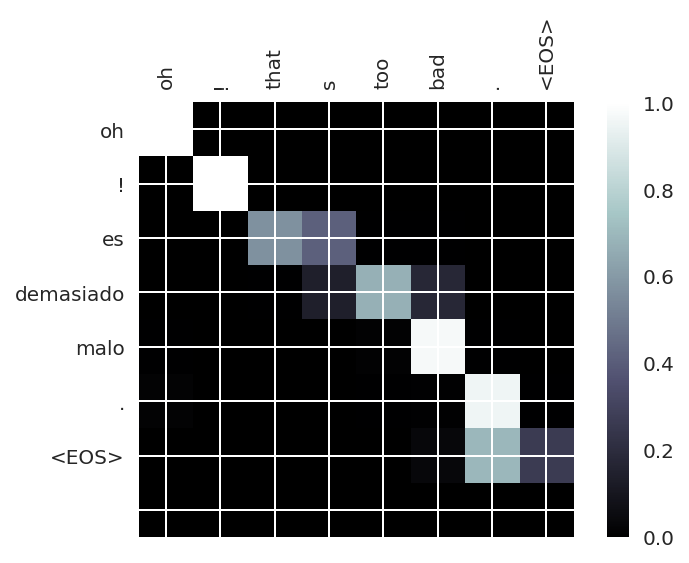

In [218]:
evaluator.evaluate_randomly_and_show_attention(val_data)

['tom doesn t have a visa .' 'tom no tiene una visa .']
input = tom doesn t have a visa .
output = tom no tiene una visa . <EOS>


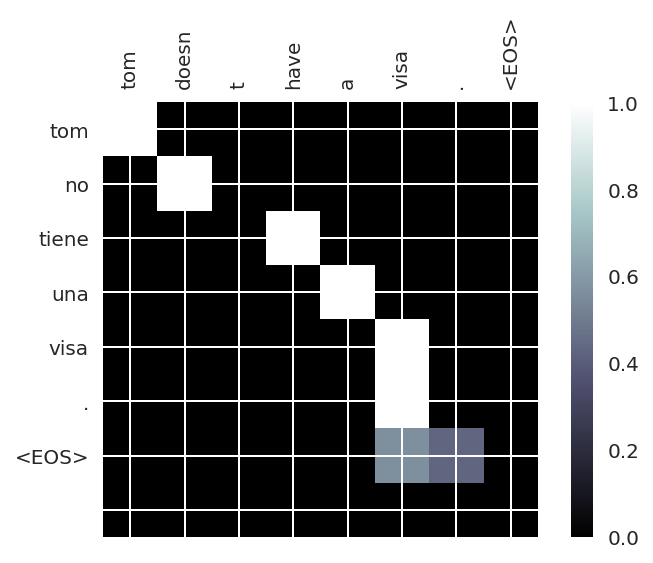

In [86]:
evaluator.evaluate_randomly_and_show_attention(val_data, k_beams=15)

['have you finished reading that novel ?', 'has terminado de leer esa novela ?']
input = have you finished reading that novel ?
output = terminaste de leer esa leer esa novela ? <EOS>


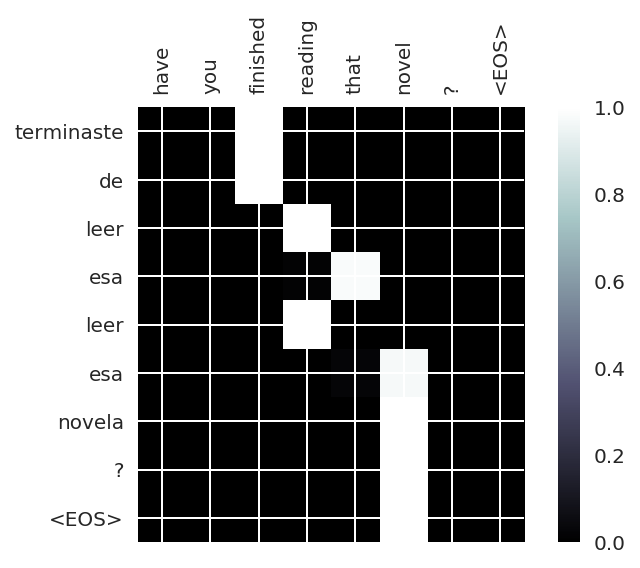

In [162]:
evaluator.evaluate_randomly_and_show_attention(val_data)

['i want to keep my car there .', 'quiero dejar mi auto ahi .']
input = i want to keep my car there .
output = quiero dejar mi carro alli . <EOS>


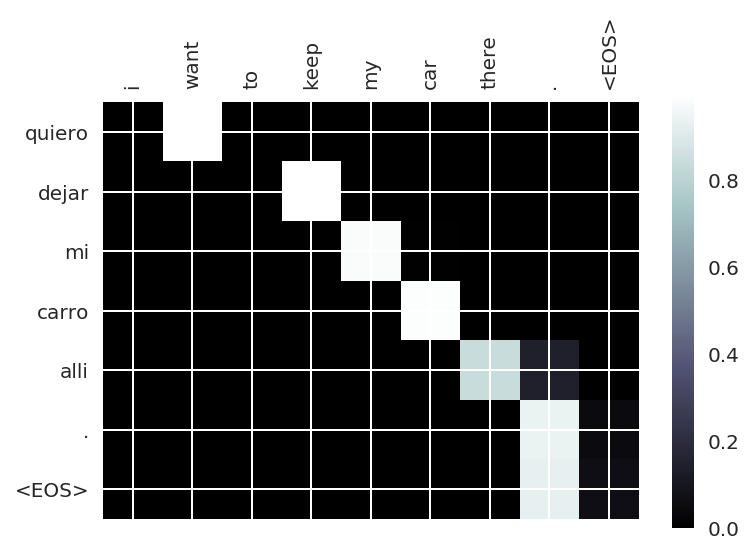

In [138]:
evaluator.evaluate_randomly_and_show_attention(val_data)

## BLEU Evaluation

In [38]:
from BLEU import BLEU
from NMT_evaluation import Evaluator

In [39]:
evaluator = Evaluator(encoder, decoder, input_lang, output_lang, 
                      MAX_LENGTH, USE_CUDA)

In [40]:
candidates, references = evaluator.get_candidates_and_references(val_data, k_beams=10)
len(candidates), len(references)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

(1000, 1000)

In [51]:
import pandas as pd
pd.Series(candidates).to_csv('NMT_candidate_bleu3954.csv', index=False)
pd.Series(references).to_csv('NMT_reference_bleu3954.csv', index=False)

In [41]:
# LSTM 5000 epochs (val) general attn + beam search + frozen pre trained embeddings (Fast text)(15 beams)
BLEU(candidates, [references])

(0.3953814580618995,
 [0.6964051811963324,
  0.4615908703798331,
  0.32621638267296243,
  0.2423146473779385],
 0.9902962601647637)

In [28]:
# LSTM 5000 epochs (val) general attn + beam search + frozen pre trained embeddings (Fast text)(15 beams)
BLEU(candidates, [references])

(0.2939856267804761,
 [0.6392592592592593, 0.3676521739130435, 0.23010526315789473, 0.1544],
 0.9725324350085249)

In [109]:
# LSTM 5000 epochs (val) general attn + beam search + frozen pre trained embeddings (Fast text)(15 beams)
BLEU(candidates, [references])

(0.4119611510768255,
 [0.7041900265565063,
  0.4781931464174455,
  0.3444956048555881,
  0.2586024351508735],
 0.9898716466586122)

In [106]:
# LSTM 5000 epochs (val) general attn + beam search + frozen pre trained embeddings (Fast text)(5 beams)
BLEU(candidates, [references])

(0.40872864535129005,
 [0.7075780089153046,
  0.4794066317626527,
  0.34376321353065536,
  0.25656836461126004],
 0.9827654004991255)

In [41]:
# LSTM 5000 epochs (val) general attn + beam search + pre trained embeddings (Fast text)(15 beams)
BLEU(candidates, [references])

(0.38971861880073677,
 [0.7066506530550968,
  0.46811517399752695,
  0.3304012014589144,
  0.23600109259765092],
 0.9724625286579062)

In [302]:
# LSTM 5000 epochs (val) general attn + beam search (15 beams)
BLEU(candidates, [references])

(0.39384492805332694,
 [0.7068040654997176,
  0.4712360289283366,
  0.32277734067663255,
  0.2238001958863859],
 1)

In [284]:
# LSTM 2000 epochs (val) general attn + beam search (15 beams)
BLEU(candidates, [references])

(0.30980217460179316,
 [0.641708338964725,
  0.3908423191123613,
  0.2407853306167809,
  0.15253466696976586],
 1)

In [282]:
# LSTM 2000 epochs (val) general attn + beam search (3 beams)
BLEU(candidates, [references])

(0.29989853831570157,
 [0.6347907725321889,
  0.38150557620817843,
  0.23075513196480937,
  0.14474865350089766],
 1)

In [137]:
# LSTM 5000 epochs (val) general attn
BLEU(candidates, [references])

(0.3718499114472677,
 [0.6864465803036635,
  0.44764525004045963,
  0.30025101370921026,
  0.20722660923665948],
 1)

In [135]:
# LSTM 5000 epochs (train)
BLEU(candidates, [references])

(0.6142924358810866,
 [0.8284422018419697,
  0.6710421327423769,
  0.5513880690505459,
  0.4645487572908309],
 1)

In [165]:
# GRU 5000 epochs (val) dot attn
BLEU(candidates, [references])

(0.25755678578817526,
 [0.6115431846090872,
  0.3506083109495971,
  0.1944079564646275,
  0.10556710556710557],
 1)

In [140]:
BLEU(candidates, [references])

(0.17398898274903263,
 [0.5454286933030001,
  0.2773081385711918,
  0.12278958871448441,
  0.04934292090255393],
 1)